In [102]:
%matplotlib notebook

import glob
import argparse
import numpy              as np
import matplotlib.pyplot as plt
import os

from scipy.interpolate    import interp1d
from scipy.interpolate    import interp2d
from scipy                import integrate
from astropy.io           import fits
from scipy                import stats
from scipy.optimize       import curve_fit
from scipy                import signal


os.environ['pandeia_refdata'] = "/home/maryhallow/Desktop/python/Reionizatoin/JWSTUserTraining2016/pandeia_data"
os.environ['PYSYN_CDBS'] = "/home/maryhallow/Desktop/python/Reionizatoin/JWSTUserTraining2016/cdbs.23.1.rc3"

from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc

# detectors' pixel size
HST_WFC3CAM_pixel_size = 0.13   # arcsec per pixel
JWST_NIRCAM_pixel_size = 0.032  # arcsec per pixel

# Constants
cm_in_pc = 3.0857e18
sun_luminosity = 3.828e33
arcsec_in_rad = 206265

# Cosmo params
Omega_lam = 0.7274
Omega_M_0 = 0.2726
Omega_k = 0.0
h = 0.704

# Functions to compute Angular diameter distance D_A [Mpc]
E   = lambda x: 1/np.sqrt(Omega_M_0*np.power(1+x,3)+Omega_lam+Omega_k*np.power(1+x,2))
D_m = lambda x: D_c(x)
D_c = lambda x: (9.26e27/h)*integrate.quad(E, 0, x)[0]
D_A = lambda x: D_m(x)/(1+x)/cm_in_pc/1e6  # Angular distance [Mpc]

<IPython.core.display.Javascript object>


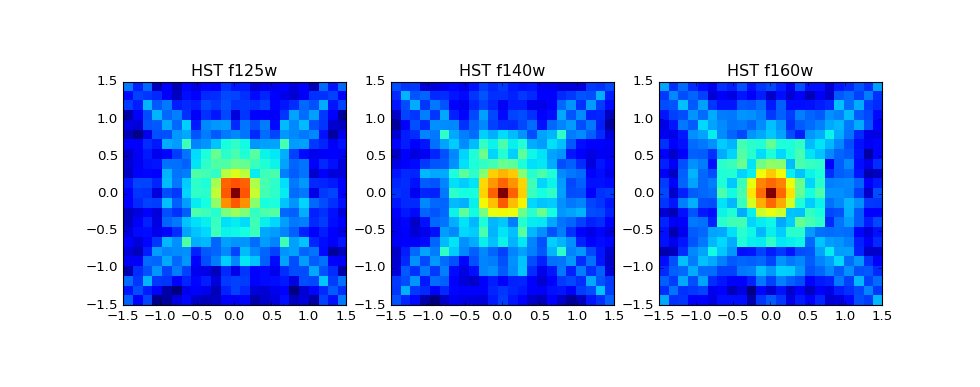

2.99


In [133]:
a = fits.open('data/psf_test_f125w00_psf.fits')[0].data[1:,1:]
b = fits.open('data/psf_test_f140w00_psf.fits')[0].data[1:,1:]
c = fits.open('data/psf_test_f160w00_psf.fits')[0].data[1:,1:]

coords_a = np.linspace(-1.5 + 1.5/np.shape(a)[0],1.5 - 1.5/np.shape(a)[0],np.shape(a)[0])
coords_b = np.linspace(-1.5 + 1.5/np.shape(b)[0],1.5 - 1.5/np.shape(b)[0],np.shape(b)[0])
coords_c = np.linspace(-1.5 + 1.5/np.shape(c)[0],1.5 - 1.5/np.shape(c)[0],np.shape(c)[0])

NNbins = int(3/HST_WFC3CAM_pixel_size)
pix_edges  = np.linspace(-1.5,1.5,NNbins+1)

x, y = np.meshgrid(coords_a, coords_a)
psf_f125w,X,Y =np.histogram2d(x.flatten(), y.flatten(), bins=(pix_edges, pix_edges), weights = a.flatten())
x, y = np.meshgrid(coords_b, coords_b)
psf_f140w,X,Y =np.histogram2d(x.flatten(), y.flatten(), bins=(pix_edges, pix_edges), weights = b.flatten())
x, y = np.meshgrid(coords_c, coords_c)
psf_f160w,X,Y =np.histogram2d(x.flatten(), y.flatten(), bins=(pix_edges, pix_edges), weights = c.flatten())

plt.figure(1)
plt.subplot(1,3,1)
plt.title('HST f125w')
plt.imshow(np.log10(psf_f125w),interpolation='nearest',extent=[-1.5,1.5,-1.5,1.5])

plt.subplot(1,3,2)
plt.title('HST f140w')
plt.imshow(np.log10(psf_f140w),interpolation='nearest',extent=[-1.5,1.5,-1.5,1.5])

plt.subplot(1,3,3)
plt.title('HST f160w')
plt.imshow(np.log10(psf_f160w),interpolation='nearest',extent=[-1.5,1.5,-1.5,1.5])

plt.show()

print(np.shape(psf_f125w)[0]*HST_WFC3CAM_pixel_size)

<IPython.core.display.Javascript object>


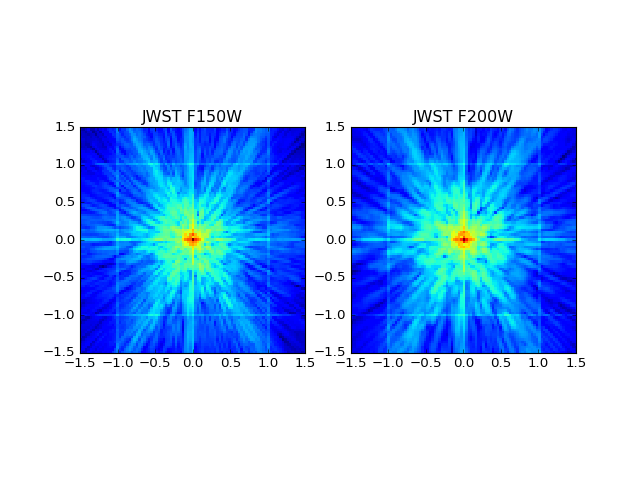

2.976


In [138]:
A = fits.open('data/PSF_NIRCam_F150W.fits')[0].data
B = fits.open('data/PSF_NIRCam_F200W.fits')[0].data

coords_A = np.linspace(-1.5 + 1.5/np.shape(A)[0],1.5 - 1.5/np.shape(A)[0],np.shape(A)[0])
coords_B = np.linspace(-1.5 + 1.5/np.shape(B)[0],1.5 - 1.5/np.shape(B)[0],np.shape(B)[0])

NNbins = int(3/JWST_NIRCAM_pixel_size)
pix_edges  = np.linspace(-1.5,1.5,NNbins+1)

x, y = np.meshgrid(coords_A, coords_A)
psf_F150W,X,Y =np.histogram2d(x.flatten(), y.flatten(), bins=(pix_edges, pix_edges), weights = A.flatten())
x, y = np.meshgrid(coords_B, coords_B)
psf_F200W,X,Y =np.histogram2d(x.flatten(), y.flatten(), bins=(pix_edges, pix_edges), weights = B.flatten())

plt.figure(2)
plt.subplot(1,2,1)
plt.title('JWST F150W')
plt.imshow(np.log10(psf_F150W),interpolation='nearest',extent=[-1.5,1.5,-1.5,1.5])

plt.subplot(1,2,2)
plt.title('JWST F200W')
plt.imshow(np.log10(psf_F200W),interpolation='nearest',extent=[-1.5,1.5,-1.5,1.5])

plt.show()

print(np.shape(psf_F150W)[0]*JWST_NIRCAM_pixel_size)

In [82]:
coll_area    = 254009.0 # cm2
c            = 2.9927e10
nu = c/(x[::-1]*1e-4)

filter_JWST   = np.loadtxt('data/filter_F150W.dat',skiprows=1)
filter_HST    = np.loadtxt('data/filter_f140w.dat')

F_JWST = interp1d(filter_JWST[:,0],filter_JWST[:,1],fill_value=0.0,bounds_error=False)
F_HST  = interp1d(filter_HST[:,0]/1e4,filter_HST[:,1],fill_value=0.0,bounds_error=False)
flux_calculated_HST  = integrate.trapz(F_HST(x[::-1])*y[::-1],nu)  #/integrate.trapz(F_HST(x),x)

photons_wave  = coll_area * 1.5091905 * y / x
photons_norm  = coll_area * 1.5091905 * 1 / x
normalization = integrate.trapz(F_JWST(x)*photons_norm,x)

noise = np.vstack((stats.norm.rvs(-0.00015609,0.00275845,500),
                       stats.norm.rvs(-3.24841830e-05,3.26572605e-03,500),
                       stats.norm.rvs(-0.00020178,0.00239519,500)))

zero_point = np.array([26.23,26.45,25.94])
coeff = 10 ** (0.4 * (zero_point + 48.6))

noise[0,:] = noise[0,:] * 1e23 * 1e9 / coeff[0]
noise[1,:] = noise[1,:] * 1e23 * 1e9 / coeff[1]
noise[2,:] = noise[2,:] * 1e23 * 1e9 / coeff[2]

coeff_125 = 1e23 * 1e9 / coeff[0]
coeff_140 = 1e23 * 1e9 / coeff[1]
coeff_160 = 1e23 * 1e9 / coeff[2]

print(coeff_140)
print(1e6/normalization)

95.4992586021
27.184285605


In [85]:
# to generate spectrum

x = np.linspace(0.5,2.5,200)
y = stats.norm.pdf(x,loc=1.5,scale=0.05) * 1e-26

def func_trial(x,a,b):
    return stats.norm.pdf(x,loc=a, scale=b)

number_of_exp =  np.array([2,44,309,1614,5473,16144]) # hour, day, week, 1/10 yr, f140w exp time, 1 yr

loc1 = []
scale1 =  []
on_source_time = []

for i in range(0,len(number_of_exp)):
    calc_input = build_default_calc('jwst', 'nircam', 'sw_imaging')

    spec = [x,y]

    calc_input['scene'][0]['spectrum']['sed'] = {"sed_type": "input", "spectrum": spec}
    calc_input['scene'][0]['spectrum']['normalization']['type'] = 'none'
    calc_input['configuration']['max_scene_size'] = 30


    calc_input['background'] = 'low'

    calc_input['configuration']['instrument']['filter'] = 'f150w'
    calc_input['configuration']['detector']['nexp'] = number_of_exp[i]

    calc_input['strategy']['aperture_size'] = 0.1
    calc_input['strategy']['sky_annulus'] = [0.7, 0.9]


    report = perform_calculation(calc_input, dict_report=False, webapp=True)
    report_dict = report.as_dict()
    report_fits = report.as_fits()

    flux  = report_dict['scalar']['extracted_flux']
    print('on source time = ', report_dict['scalar']['on_source_time'],' sec')
    on_source_time.append(report_dict['scalar']['on_source_time'])
    
    shape  = np.shape(report_dict['2d']['detector'])[0]
    sample = np.array(report_dict['2d']['detector']).reshape(shape*shape)
    
    pdf = stats.gaussian_kde(sample)
    grid_points_pdf = pdf.evaluate(sample)
    popt, pcov = curve_fit(func_trial, sample, grid_points_pdf)
    
    loc1.append(popt[0])
    scale1.append(popt[1])
    print(loc1[i],scale1[i])

    
number_of_exp2 =  np.logspace(0,np.log10(16144),30) 

loc2 = []
scale2 =  []
on_source_time2 = []

for i in range(0,len(number_of_exp2)):
    calc_input = build_default_calc('jwst', 'nircam', 'sw_imaging')

    spec = [x,y]

    calc_input['scene'][0]['spectrum']['sed'] = {"sed_type": "input", "spectrum": spec}
    calc_input['scene'][0]['spectrum']['normalization']['type'] = 'none'
    calc_input['configuration']['max_scene_size'] = 30


    calc_input['background'] = 'low'

    calc_input['configuration']['instrument']['filter'] = 'f150w'
    calc_input['configuration']['detector']['nexp'] = number_of_exp2[i]

    calc_input['strategy']['aperture_size'] = 0.1
    calc_input['strategy']['sky_annulus'] = [0.7, 0.9]


    report = perform_calculation(calc_input, dict_report=False, webapp=True)
    report_dict = report.as_dict()
    report_fits = report.as_fits()

    flux = 1e6*report_dict['2d']['detector']/normalization
    print('on source time = ', report_dict['scalar']['on_source_time'],' sec')
    on_source_time2.append(report_dict['scalar']['on_source_time'])
    
    shape  = np.shape(report_dict['2d']['detector'])[0]
    sample = np.array(flux).reshape(shape*shape)
    
    pdf = stats.gaussian_kde(sample)
    grid_points_pdf = pdf.evaluate(sample)
    popt, pcov = curve_fit(func_trial, sample, grid_points_pdf)
    
    loc2.append(popt[0])
    scale2.append(popt[1])
    print(loc2[i],scale2[i])

/home/maryhallow/anaconda3/envs/jwst-workshop/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


on source time =  3909.36  sec
0.161736314518 0.00733914183578
on source time =  86005.92  sec
0.16164684841 0.00197004588209
on source time =  603996.12  sec
0.161636623628 0.00135642985834
on source time =  3154853.52  sec
0.161634872646 0.00125134888301
on source time =  10697963.64  sec
0.161634565778 0.00123293305444
on source time =  31556353.92  sec
0.161634480135 0.00122779319208
on source time =  1954.68  sec
4.39803033377 0.280176255639
on source time =  2730.10595373  sec
4.39732312578 0.237735060455
on source time =  3813.14512789  sec
4.39672669225 0.201941415833
on source time =  5325.82837912  sec
4.39622431589 0.171792410177
on source time =  7438.59647941  sec
4.39580189788 0.146442039258
on source time =  10389.5044385  sec
4.39544755396 0.12517693173
on source time =  14511.044224  sec
4.39515126023 0.107395549265
on source time =  20267.6081153  sec
4.39490455458 0.0925901149217
on source time =  28307.8138537  sec
4.39470027403 0.0803307257892
on source time =  395

<IPython.core.display.Javascript object>


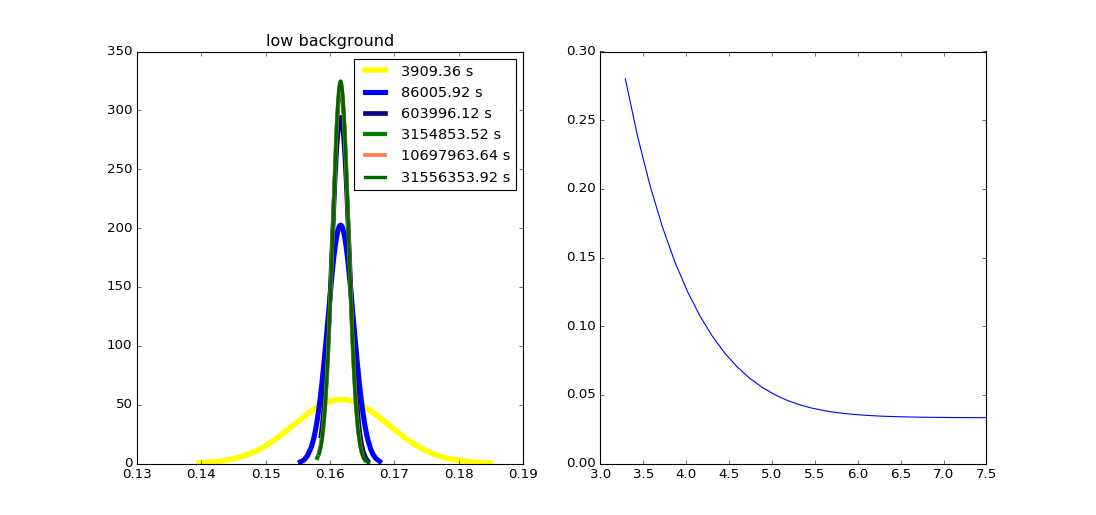

[0.16173631451807766, 0.16164684841009219, 0.16163662362795547, 0.16163487264591389, 0.16163456577827345, 0.16163448013461162]
[0.0073391418357847396, 0.0019700458820937623, 0.0013564298583426228, 0.0012513488830113986, 0.0012329330544371766, 0.0012277931920835045]


In [86]:
plt.figure(4)
plt.subplot(1,2,2)
plt.plot(np.log10(on_source_time2),scale2)

print(loc1)
print(scale1)
yr_in_sec = 31536000 
colors = np.array(['yellow','blue','darkblue','green','coral','darkgreen','red','chocolate','orange','violet'])
line_thickness = np.array([5,4.6,4.2,3.8,3.4,3.0,2.6,2.2,1.8,1.4,1.0])
plt.figure(4)
plt.subplot(1,2,1)

plt.title('low background')
for i in range(0,len(loc1)):
    sample = stats.norm.rvs(loc=loc1[i],scale=scale1[i],size=500)
    plt.plot(np.sort(sample),stats.norm.pdf(np.sort(sample),loc=loc1[i],scale=scale1[i]),color=colors[i],lw=line_thickness[i]
            ,label=str(on_source_time[i]) + ' s')


plt.legend(loc='upper right',fontsize=13)    
plt.show()

<IPython.core.display.Javascript object>


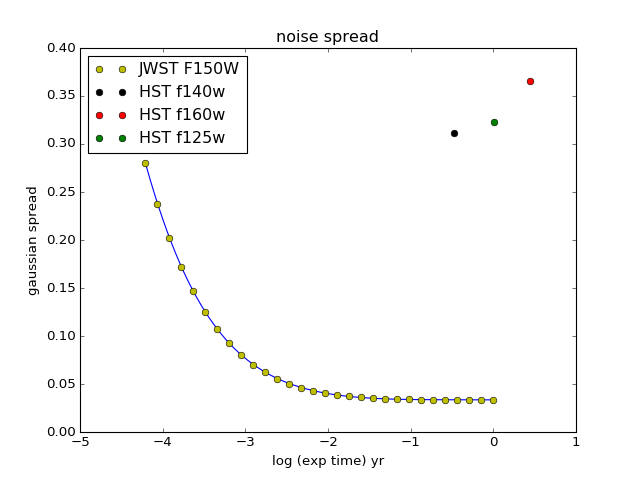

In [98]:
def func_trial_2(x,a,b,c,d,e):
    X = np.log10(x)
    return a + b/X + c/X/X + d/X/X/X + e/X/X/X/X

popt, pcov = curve_fit(func_trial_2,on_source_time2, scale2)

sample = np.logspace(np.log10(on_source_time2[0]),np.log10(on_source_time2[-1]),500)
plt.figure(5)
plt.title('noise spread')
plt.plot(np.log10(sample/yr_in_sec),func_trial_2(sample,*popt))
plt.plot(np.log10(np.array(on_source_time2)/yr_in_sec),scale2,'yo',label='JWST F150W')
plt.xlabel('log (exp time) yr')
plt.ylabel('gaussian spread')
plt.plot(np.log10(86.7*1e3*122/yr_in_sec),3.26572605e-03*coeff_140,'ko',label='HST f140w')
plt.plot(np.log10(236.1*1e3*366/yr_in_sec),0.00239519*coeff_160,'ro',label='HST f160w')
plt.plot(np.log10(112.5*1e3*289/yr_in_sec),0.00275845*coeff_125,'go',label='HST f125w')
plt.legend(loc='upper left')

In [115]:
x = np.linspace(0.5,2.5,200)
y = stats.norm.pdf(x,loc=1.5,scale=0.05) * 1e-3

calc_input = build_default_calc('jwst', 'nircam', 'sw_imaging')

#The 0th index is taken to be wavelength in units of 'mJy'.
#The 1st index is taken to be the flux in units of 'microns'.
spec = [x,y]
    
calc_input['scene'][0]['spectrum']['sed'] = {"sed_type": "input", "spectrum": spec}
calc_input['scene'][0]['spectrum']['normalization']['type'] = 'none'
calc_input['configuration']['max_scene_size'] = 30


calc_input['background'] = 'low'

calc_input['configuration']['instrument']['filter'] = 'f150w'
calc_input['configuration']['detector']['nexp'] = 1

calc_input['strategy']['aperture_size'] = 0.1
calc_input['strategy']['sky_annulus'] = [0.7, 0.9]


report = perform_calculation(calc_input, dict_report=False, webapp=True)
report_dict2 = report.as_dict()
report_fits2 = report.as_fits()

print(report_dict2['scalar'])

/home/maryhallow/anaconda3/envs/jwst-workshop/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


{'extracted_flux': 77.72419772728065, 'x_offset': 0.0, 'all_dithers_time': 1954.68, 'background_total': 5.0063205363484675, 'filter': 'f150w', 'background': 0.17430911172250863, 'contamination': 0.009600756470743807, 'aperture_size': 0.1, 'extracted_noise': 0.2982663071755678, 'y_offset': 0.0, 'cr_ramp_rate': 0.1551109231922884, 'reference_wavelength': 1.499433773572337, 'background_area': 981.74770424681026, 'background_sky': 4.958256072064502, 'on_source_time': 1954.68, 'extraction_area': 30.679615757712813, 'disperser': None, 'sn': 260.58658271961656}


In [116]:
photons_wave  =  y / x
photons_norm  =  1 / x
flux_nJy      = 1e6*integrate.trapz(F_JWST(x)*photons_wave,x)/integrate.trapz(F_JWST(x)*photons_norm,x)

<IPython.core.display.Javascript object>


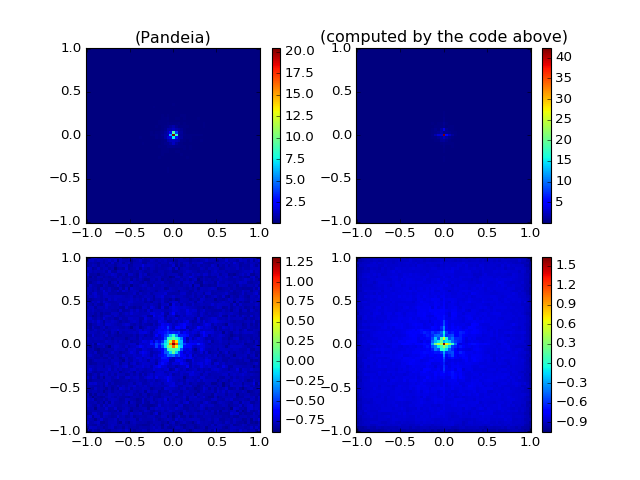

(63, 63)


In [140]:
detector_plane = stats.norm.rvs(4.39412796129,0.280176255639,shape*shape).reshape((shape,shape))
detector_plane[31,31] = flux_nJy
detector_plane_convolved = signal.fftconvolve(detector_plane, psf_F150W[20:-20,20:-20], mode='same')

plt.figure(8)

t = report_dict['transform']
extent = [t['x_min'], t['x_max'], t['y_min'], t['y_max']]

print(np.shape(report_dict['2d']['snr']))

plt.subplot(2,2,1)
plt.title('(Pandeia)')
plt.imshow(report_dict2['2d']['detector'], interpolation='nearest',extent=extent)
plt.colorbar(orientation='vertical')

plt.subplot(2,2,2)
plt.title('(computed by the code above)')
plt.imshow(detector_plane_convolved*normalization/1e6, interpolation='nearest',extent=extent)
plt.colorbar(orientation='vertical')

plt.subplot(2,2,3)
plt.imshow(np.log10(report_dict2['2d']['detector']), interpolation='nearest',extent=extent)
plt.colorbar(orientation='vertical')


plt.subplot(2,2,4)
plt.imshow(np.log10(detector_plane_convolved*normalization/1e6), interpolation='nearest',extent=extent)
plt.colorbar(orientation='vertical')

plt.show()

In [141]:
print(report_dict2['scalar']['extracted_flux'])
print(np.sum(detector_plane_convolved[31-2:31+3,31-2:31+3]*normalization*1e-6))
print(popt)

77.72419772728065
76.9751251707
[  -0.35867483    9.1144785   -75.60172247  256.44825309 -275.1335303 ]
